In [15]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[search_keyword])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

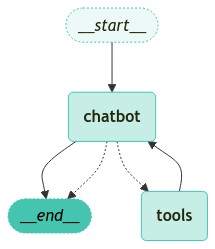

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 노드의 단계별 출력
### 스트리밍 모드

- values: 각 단계의 현재 상태 값 출력
- updates: 각 단계의 상태 업데이트만 출력 (기본값)
- messages: 각 단계의 메시지 출력
여기서 스트리밍의 의미는 LLM 출력시 토큰 단위로 스트리밍하는 개념이 아니라, 단계별로 출력하는 의미를 가집니다.

- stream_mode = "values"
- values 모드는 각 단계의 현재 상태 값을 출력합니다.

### 참고

- chunk.items()
    - key: State 의 key 값
    - value: State 의 key 에 대한하는 value

### 동기(Synchronous) 방식의 스트리밍
chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)

In [17]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="values")
for chunk in graph.stream(inputs, stream_mode="values"):

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_JZGrgd54NxJYJ4maRFQJcqeC)
 Call ID: call_JZGrgd54NxJYJ4maRFQJcqeC
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- NVIDIA와 소프트뱅크의 협업, 글로벌 AI 강국 위한 지원 강화 - NVIDIA 블로그
- 아마존, 엔비디아에 도전장... '우리 칩 사용하는 AI연구자에 컴퓨팅 파워 무료 제공' - 조선일보
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
================================== Ai Message ==================================

최신 AI 관련 뉴스는 다음과 같습니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **NVIDIA와 소프트뱅크의 협업, 글로벌 AI 강국 위한 지원 강화** - NVIDIA 블로그
4. **아마존, 엔비디아에 도전장... '우리 칩 사용하는 AI연구자에 컴퓨팅 파워 무료 제공'** - 조선일보
5. **젠슨황 "AI 모든 산업에 영향"…손정의 "

## 비동기(Asynchronous) 방식의 스트리밍
### 참고

astream() 메서드는 비동기 스트림 처리를 통해 그래프를 실행하고 값 모드로 청크 단위 응답을 생성합니다.<br>
async for 문을 사용하여 비동기 스트림 처리를 수행합니다.

In [25]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="values")
for chunk in graph.stream(inputs, stream_mode="values"):

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_L9r3GlSKtnu6Y53Qpu7eT8xZ)
 Call ID: call_L9r3GlSKtnu6Y53Qpu7eT8xZ
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그
================================== Ai Message ==================================

다음은 AI와 관련된 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더

### 최종 결과만 스트리밍

In [21]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

final_result = None

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

# 최종 결과 출력
print(final_result["messages"][-1].content)

최신 AI 관련 뉴스는 다음과 같습니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
4. **소프트뱅크 손정의, 엔비디아와 손잡고 AI 슈퍼컴 만든다** - 연합뉴스
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 사항이 있으시면 말씀해 주세요!


### stream_mode = "updates"
- updates 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다.

- 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 dictionary 입니다.

### 참고

- chunk.items()
    - key: 노드(Node) 의 이름
    - value: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.
### 동기(Synchronous) 방식의 스트리밍

In [24]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="updates")
for chunk in graph.stream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_VUMDPMHwHq6FdU8LHDt5AcBe)
 Call ID: call_VUMDPMHwHq6FdU8LHDt5AcBe
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

[Node: chatbot]

================================== Ai Message ==================================

최신 AI 관련 뉴스는 다음과 같습니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

이 뉴스들은 AI의 영향, 직업 변화, 그리고 주요 기업들의 움직임에 대해 다루고 있습니

### 비동기(Asynchronous) 방식의 스트리밍

In [23]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="updates")
async for chunk in graph.astream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_9U3cWnyPMMlt73pFJLMFOasu)
 Call ID: call_9U3cWnyPMMlt73pFJLMFOasu
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 소프트뱅크 손정의, 엔비디아와 손잡고 AI 슈퍼컴 만든다 - 연합뉴스
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

[Node: chatbot]

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
4. **소프트뱅크 손정의, 엔비디아와 손잡고 AI 슈퍼컴 만든다** - 연합뉴스
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 내용이 있으면 말씀해 주세요!


### stream_mode = "messages"
- messages 모드는 각 단계에 대한 메시지를 스트리밍합니다.

### 참고

- chunk 는 두 개의 요소를 가진 tuple 입니다.
    - chunk_msg: 실시간 출력 메시지
    - metadata: 노드 정보

### 동기(Synchronous) 방식의 스트리밍

In [28]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):

    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)

    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ['branch:chatbot:tools_condition:tools'], 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:627e5723-c7aa-c299-1948-a9a8086f23ad'}


최근 AI 관련 뉴스는 다음과 같습니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 자세한 내용이 필요하시면 말씀해 주세요!

### 비동기(Asynchronous) 방식의 스트리밍

In [27]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그
다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 내용이 있으시면 말씀해 주세요!

## 특정 노드에 대한 출력 스트리밍
### 참고

metadata["langgraph_node"] 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

In [32]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["MY_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["MY_STREAM"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    # 서브그래프용 상태 그래프 생성
    subgraph = StateGraph(State)

    # 챗봇 노드 추가
    subgraph.add_node("chatbot", chatbot)

    # 도구 노드 생성 및 추가
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    # 조건부 엣지 추가
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)

# 서브그래프 추가
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# SNS 포스트 생성 노드 추가
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# 그래프 컴파일
graph = graph_builder.compile()

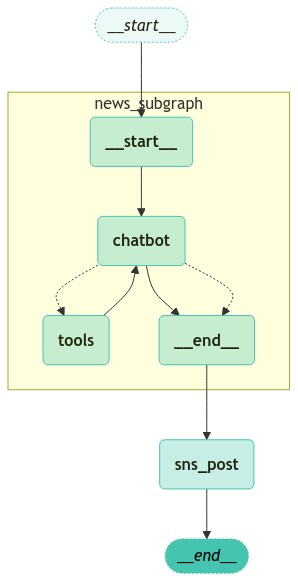

In [10]:
from langchain_teddynote.graphs import visualize_graph
# 그래프 시각화
visualize_graph(graph, xray=True)

특정 노드(Node) 에 대해서 출력하고 싶은 경우, stream_mode="messages" 를 통해 설정할 수 있습니다.

stream_mode="messages" 설정시, (chunk_msg, metadata) 형태로 메시지를 받습니다.

chunk_msg 는 실시간 출력 메시지,
metadata 는 노드 정보를 의미합니다.
metadata["langgraph_node"] 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.

(예시) chatbot 노드에서 출력된 메시지만 출력하는 경우

metadata["langgraph_node"] == "chatbot"

In [29]:
from langchain_core.messages import HumanMessage

# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# stream_mode="messages" 를 통한 스트리밍 처리
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # HumanMessage 가 아닌 최종 노드의 유효한 컨텐츠만 출력 처리
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)

다음은 AI와 관련된 최신 뉴스들입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 알고 싶은 내용이 있으면 말씀해 주세요!

In [30]:
metadata

{'langgraph_step': 3,
 'langgraph_node': 'chatbot',
 'langgraph_triggers': ['tools'],
 'langgraph_path': ('__pregel_pull', 'chatbot'),
 'langgraph_checkpoint_ns': 'chatbot:8b73713d-6c8d-022c-8938-3468e0cd5f73',
 'checkpoint_ns': 'chatbot:8b73713d-6c8d-022c-8938-3468e0cd5f73',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-4o-mini',
 'ls_model_type': 'chat',
 'ls_temperature': 0.7}

## 사용자 정의 tag 필터링 된 스트리밍
LLM 의 출력이 여러 군데에서 발생하는 경우, 특정 노드에서 출력된 메시지만 출력하고 싶은 경우가 있습니다.

이러한 경우, tags 를 추가하여 출력하고 싶은 노드만 선별할 수 있습니다.

llm 에 tags 를 추가하는 방법은 다음과 같습니다. tags 는 리스트 형태로 추가할 수 있습니다.

llm.with_config(tags=["WANT_TO_STREAM"])

이를 통해 이벤트를 더 정확하게 필터링하여 해당 모델에서 발생한 이벤트만 유지할 수 있습니다.

아래 예시는 WANT_TO_STREAM 태그가 있는 경우만 출력하는 예시입니다.

In [33]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 이벤트 스트림 처리(astream_events)
async for event in graph.astream_events(inputs, version="v2"):
    # 이벤트 종류와 태그 정보 추출
    kind = event["event"]
    tags = event.get("tags", [])

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    if kind == "on_chat_model_stream" and "MY_STREAM" in tags:
        # 이벤트 데이터 추출
        data = event["data"]

        # 출력 메시지
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 내용이나 특정 주제에 대한 추가 정보가 필요하시면 말씀해 주세요!🚀 AI의 시대가 다가오고 있어요! 🌐 최근 뉴스에 따르면, AI가 모든 산업에 영향을 미치고 있다고 합니다. 🏭💼 단순 노동직이 사라질 위기! 😲 엔비디아와 소프트뱅크도 AI 슈퍼컴 구축에 나선다네요. 🔍💻 우리 미래는 어떻게 변할까요? 🤔 #AI #엔비디아 #미래의직업 #기술혁신

In [14]:
# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}


# 네임스페이스 문자열을 보기 좋은 형식으로 변환하는 포맷팅 함수
def format_namespace(namespace):
    return namespace[-1].split(":")[0] if len(namespace) > 0 else "parent graph"


# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(
            f"\n========= Update from node [{node_name}] in [{namespace}] =========\n"
        )

        # 노드의 청크 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node [chatbot] in [('news_subgraph:bfc43c04-2e7e-20a9-32a6-eab7645a5e77',)] =========

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_sbfy07SeD4WqL4NjSM6Xoh4m)
 Call ID: call_sbfy07SeD4WqL4NjSM6Xoh4m
  Args:
    query: AI

========= Update from node [tools] in [('news_subgraph:bfc43c04-2e7e-20a9-32a6-eab7645a5e77',)] =========

================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- NVIDIA와 소프트뱅크의 협업, 글로벌 AI 강국 위한 지원 강화 - NVIDIA 블로그
- 아마존, 엔비디아에 도전장... '우리 칩 사용하는 AI연구자에 컴퓨팅 파워 무료 제공' - 조선일보
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스

========= Update from node [chatbot] in [('news_subgraph:bfc43c04-2e7e-20a9-32a6-eab7645a5e77',)] =========

================================== Ai Message ==================================

최신 AI 관련 뉴스는 다음과 같습니다:

1. **왜 AI는 노동해방


| event                | name             | chunk                           | input                                         | output                                          |
|----------------------|------------------|---------------------------------|-----------------------------------------------|-------------------------------------------------|
| on_chat_model_start  | [model name]     |                                 | {"messages": [[SystemMessage, HumanMessage]]} |                                                 |
| on_chat_model_stream | [model name]     | AIMessageChunk(content="hello") |                                               |                                                 |
| on_chat_model_end    | [model name]     |                                 | {"messages": [[SystemMessage, HumanMessage]]} | AIMessageChunk(content="hello world")           |
| on_llm_start         | [model name]     |                                 | {'input': 'hello'}                            |                                                 |
| on_llm_stream        | [model name]     | 'Hello'                         |                                               |                                                 |
| on_llm_end           | [model name]     |                                 | 'Hello human!'                                |                                                 |
| on_chain_start       | format_docs      |                                 |                                               |                                                 |
| on_chain_stream      | format_docs      | "hello world!, goodbye world!"  |                                               |                                                 |
| on_chain_end         | format_docs      |                                 | [Document(...)]                               | "hello world!, goodbye world!"                  |
| on_tool_start        | some_tool        |                                 | {"x": 1, "y": "2"}                            |                                                 |
| on_tool_end          | some_tool        |                                 |                                               | {"x": 1, "y": "2"}                              |
| on_retriever_start   | [retriever name] |                                 | {"query": "hello"}                            |                                                 |
| on_retriever_end     | [retriever name] |                                 | {"query": "hello"}                            | [Document(...), ..]                             |
| on_prompt_start      | [template_name]  |                                 | {"question": "hello"}                         |                                                 |
| on_prompt_end        | [template_name]  |                                 | {"question": "hello"}                         | ChatPromptValue(messages: [SystemMessage, ...]) |

In addition to the standard events, users can also dispatch custom events (see example below).

Custom events will be only be surfaced with in the `v2` version of the API!

A custom event has following format:

| Attribute | Type | Description                                                                                               |
|-----------|------|-----------------------------------------------------------------------------------------------------------|
| name      | str  | A user defined name for the event.                                                                        |
| data      | Any  | The data associated with the event. This can be anything, though we suggest making it JSON serializable.  |


In [6]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= on_chat_model_start =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- NVIDIA와 소프트뱅크의 협업, 글로벌 AI 강국 위한 지원 강화 - NVIDIA 블로그
- 젠슨 황 "앞으로는 모두가 AI 직원과 함께 일하게 될 것" - AI타임스
- 소프트뱅크 손정의, 엔비디아와 손잡고 AI 슈퍼컴 만든다 - 연합뉴스

========= on_chat_model_start =========

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **NVIDIA와 소프트뱅크의 협업, 글로벌 AI 강국 위한 지원 강화** - NVIDIA 블로그
4. **젠슨 황 "앞으로는 모두가 AI 직원과 함께 일하게 될 것"** - AI타임스
5. **소프트뱅크 손정의, 엔비디아와 손잡고 AI 슈퍼컴 만든다** - 연합뉴스

더 궁금한 내용이 있으시면 말씀해 주세요!
========= on_chat_model_start =========

🤖✨ AI의 미래는 어떤 모습일까요? 노동해방은 언제? 단순 노동, 음식숙박업이 사라질 위기! 🚀 소프트뱅크와 NVIDIA의 협업으로 AI 슈퍼컴이 탄생한다고! 모두가 AI와 함께 일하는 시대가 온다! 🌍💼 #AI #미래기술 #노동시장변화 #NVIDIA #소프트뱅크

## 도구 호출에 대한 스트리밍 출력
- AIMessageChunk: 실시간 토큰 단위의 출력 메시지
- tool_call_chunks: 도구 호출 청크. 만약 tool_call_chunks 가 존재하는 경우, 도구 호출 청크를 누적하여 출력합니다. (도구 토큰은 이 속성을 보고 판단하여 출력)

In [36]:
from langchain_core.messages import AIMessageChunk, HumanMessage

# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 첫 번째 메시지 처리 여부 플래그 설정
first = True

# 비동기 스트림 처리를 통한 메시지 및 메타데이터 순차 처리
for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # 사용자 메시지가 아닌 경우의 컨텐츠 출력 처리
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    # AI 메시지 청크 처리 및 누적
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # 도구 호출 청크 존재 시 누적된 도구 호출 정보 출력
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])

{}
{}
{}
{'query': ''}
{'query': 'AI'}
{'query': 'AI'}
- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 점이나 특정 주제에 대한 정보가 필요하시면 알려주세요!🌟 AI의 미래, 지금 주목하세요! 🚀 최근 AI가 노동시장에서 큰 변화를 몰고 올 것으로 예상되고 있습니다. 특히 음식·운수 분야에서 많은 일자리가 사라질 위험이! 😱 젠슨 황 CEO는 "모든 산업에 영향"이라고 강조했어요. #AI #노동시장 #엔비디아 #미래기술 #혁신 

## Subgraphs 스트리밍 출력
이번에는 Subgraphs 를 통해 스트리밍 출력을 확인하는 방법을 알아보겠습니다.

Subgraphs 는 그래프의 일부를 서브그래프로 정의하는 기능입니다.

### 흐름

Subgraphs 에서는 기존의 최신 뉴스를 검색하는 기능을 재사용합니다.
Parent Graph 에서는 검색된 최신 뉴스를 바탕으로 SNS 포스트를 생성하는 기능을 추가합니다.

In [37]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_teddynote.tools import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    # 서브그래프용 상태 그래프 생성
    subgraph = StateGraph(State)

    # 챗봇 노드 추가
    subgraph.add_node("chatbot", chatbot)

    # 도구 노드 생성 및 추가
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    # 조건부 엣지 추가
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)

# 서브그래프 추가
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# SNS 포스트 생성 노드 추가
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# 그래프 컴파일
graph = graph_builder.compile()

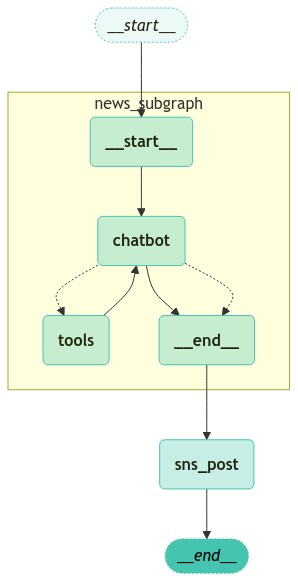

In [38]:
# 그래프 시각화
visualize_graph(graph, xray=True)

## subgraph 출력 생략

In [39]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 노드 업데이트 정보 순차적 처리 및 출력
for chunk in graph.stream(inputs, stream_mode="updates"):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        # 현재 처리 중인 노드 구분선 출력
        print(f"\n========= Update from node {node_name} =========\n")
        # 해당 노드의 업데이트된 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node news_subgraph =========

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 사항이 있으시면 말씀해 주세요!

========= Update from node sns_post =========

================================== Ai Message ==================================

🤖 AI의 미래, 우리는 어떻게 준비하고 있나요? 산업 전반에 걸쳐 AI의 영향력이 커지고 있는 지금, 단순 노동에서의 변화가 예상되고 있어요. 엔비디아와 글로벌 리더들이 AI 슈퍼컴 구축에 나서고 있답니다! 🔍💡 #AI #기술혁신 #산업변화 #엔비디아 #미래직업


subgraph 출력 포함

In [40]:
# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}


# 네임스페이스 문자열을 보기 좋은 형식으로 변환하는 포맷팅 함수
def format_namespace(namespace):
    return namespace[-1].split(":")[0] if len(namespace) > 0 else "parent graph"


# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(
            f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n"
        )

        # 노드의 청크 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_t4yFZgIG2BBtlv0J3lGmFw44)
 Call ID: call_t4yFZgIG2BBtlv0J3lGmFw44
  Args:
    query: AI

========= Update from node [tools] in [news_subgraph] =========

================================= Tool Message =================================
Name: search_keyword

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================

다음은 AI와 관련된 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아

## Subgraphs 안에서 LLM 출력 토큰 단위 스트리밍
### 참고

kind 는 이벤트 종류를 나타냅니다.
이벤트 종류는 StreamEvent 타입별 정리 에서 확인하세요!

In [41]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= on_chat_model_start =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

========= on_chat_model_start =========

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 내용이 있으면 말씀해 주세요!
========= on_chat_model_start =========

🤖🌍 AI가 모든 산업에 영향을 미치고 있다는 젠슨 황의 말! 🏭🍽️ 단순 노동직이 위험에 처해 있는데, 과연 우리는 어떤 미래를 맞이할까요? 🤔💼 #AI #노동시장 #미래기술 #엔비디아 #산업혁신

## 특정 tags 만 스트리밍 출력하는 경우
ONLY_STREAM_TAGS 를 통해 스트리밍 출력하고 싶은 tags 만 설정할 수 있습니다.
여기서는 "WANT_TO_STREAM" 는 출력에서 배제하고 "WANT_TO_STREAM2" 만 출력하는 경우를 확인합니다.

In [42]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 내용이나 특정 뉴스에 대해 알고 싶으신 점이 있으면 말씀해 주세요!
========= tags: ['seq:step:1', 'WANT_TO_STREAM2'] =========



In [43]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM", "WANT_TO_STREAM2"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- 왜 AI는 노동해방을 가져오지 못했나 - 한겨레21
- 국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동 - AI타임스
- 젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합) - 연합뉴스
- 엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서” - 매일경제
- 일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들 - NVIDIA 블로그

========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========

다음은 AI 관련 최신 뉴스입니다:

1. **왜 AI는 노동해방을 가져오지 못했나** - 한겨레21
2. **국내서 AI로 사라질 직업 1순위는 음식숙박업·운수물류업 등 단순 노동** - AI타임스
3. **젠슨황 "AI 모든 산업에 영향"…손정의 "엔비디아 3번 인수시도"(종합)** - 연합뉴스
4. **엔비디아 “소프트뱅크, 블랙웰 활용 AI 슈퍼컴 구축 나서”** - 매일경제
5. **일본 산업의 AI 도입 위해 나서는 NVIDIA와 글로벌 컨설팅 리더들** - NVIDIA 블로그

더 궁금한 사항이 있으면 말씀해 주세요!
========= tags: ['seq:step:1', 'WANT_TO_STREAM2'] =========

🤖✨ AI의 미래, 우리가 놓친 기회! 노동해방? 🤔 음식숙박, 운수물류 업종의 일자리 위기! 📉 젠슨 황의 말처럼 AI는 모든 산업을 뒤흔들고 있어요! 🌍💼 #AI #미래의직업 #엔비디아 #기술혁신 #산업변화